In [1]:
# Installing required libraries
!pip install numpy matplotlib tensorflow scikit-learn

In [2]:
# Importing thelibraries
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# Dataset directory
dataset_dir = '/home/secureslicing/Downloads/Aayam/CampusVisionChallengeFinal/MergeDataset' 

img_size = 224
batch = 64
AUTOTUNE = tf.data.AUTOTUNE

def helper_ds(subset):
  return tf.keras.utils.image_dataset_from_directory(
      dataset_dir,
      seed=123,
      validation_split=0.2,   # automatically spliting the dataset (20% for validation and rest 80% for training)
      subset=subset,
      batch_size=batch,
      image_size=(img_size, img_size)
  )

train_ds = helper_ds('training')
val_ds = helper_ds('validation')

# Displaying info
class_names = train_ds.class_names
print("Class Names:", class_names)
print("Number of Classes:", len(class_names))

# Enable prefetching and shuffling
train_ds = train_ds.shuffle(buffer_size=10000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 12597 files belonging to 10 classes.
Using 10078 files for training.
Found 12597 files belonging to 10 classes.
Using 2519 files for validation.
Class Names: ['Butler Hall', 'Carpenter Hall', 'Lee Hall', 'McCain Hall', 'McCool Hall', 'Old Main', 'Simrall Hall', 'Student Union', 'Swalm Hall', 'Walker Hall']
Number of Classes: 10


In [4]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(224, 224, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Retain class names after applying map
train_ds.class_names = class_names

In [5]:
#Double checking if train_ds exists and has class_names
if hasattr(train_ds, 'class_names'):
    print("Class Names:", train_ds.class_names)
else:
    print("Error: train_ds does not have class_names. Verify dataset creation.")

Class Names: ['Butler Hall', 'Carpenter Hall', 'Lee Hall', 'McCain Hall', 'McCool Hall', 'Old Main', 'Simrall Hall', 'Student Union', 'Swalm Hall', 'Walker Hall']


In [6]:
model = Sequential([
    data_augmentation,
    Rescaling(1./255),  # Normalize pixel values
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [7]:
# Some preliminary Adjustments before training

# Early stopping to stop the training and prevent overfitting when there is no significant improvement in each epoch

# Directory for saving checkpoints (saved temporaryly)
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Reduce learning rate when a metric has stopped improving (https://keras.io/api/callbacks/reduce_lr_on_plateau/)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6)

# Stop training when a monitored metric has stopped improving (https://keras.io/api/callbacks/early_stopping/)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # this is the no. of epochs with no improvement after which training will stop
    restore_best_weights=True
)


# For large number of epoch the kernel sometimes dies. that's why data is saved after each 10 epoch.
# for storage limitation, previous checkpoint is cleaned up when new checkpoint arrives

# Custom cleanup callback to manage intermediate checkpoints
class CleanUpCheckpoints(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, epoch_interval):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        # Saving intermediate checkpoints every `epoch_interval` epochs
        if (epoch + 1) % self.epoch_interval == 0:
            current_checkpoint = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch + 1}.keras")
            self.model.save(current_checkpoint)

            # Deleting older checkpoints
            for file in os.listdir(self.checkpoint_dir):
                if file.startswith("model_epoch_") and file != f"model_epoch_{epoch + 1}.h5":
                    os.remove(os.path.join(self.checkpoint_dir, file))
                    print(f"\nDeleted old checkpoint: {file}")


cleanup_callback = CleanUpCheckpoints(checkpoint_dir=checkpoint_dir, epoch_interval=10)

In [8]:
# THE FUN PART
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=100,
                    callbacks=[cleanup_callback,early_stopping])

Epoch 1/100
158/158 [==============================] - 32s 157ms/step - loss: 2.1584 - accuracy: 0.2167 - val_loss: 2.0272 - val_accuracy: 0.3275
Epoch 2/100
158/158 [==============================] - 31s 155ms/step - loss: 1.4651 - accuracy: 0.5023 - val_loss: 1.9348 - val_accuracy: 0.4347
Epoch 3/100
158/158 [==============================] - 31s 155ms/step - loss: 1.0470 - accuracy: 0.6521 - val_loss: 1.8911 - val_accuracy: 0.4899
Epoch 4/100
158/158 [==============================] - 31s 158ms/step - loss: 0.7933 - accuracy: 0.7318 - val_loss: 1.6045 - val_accuracy: 0.5609
Epoch 5/100
158/158 [==============================] - 31s 155ms/step - loss: 0.6435 - accuracy: 0.7887 - val_loss: 1.3216 - val_accuracy: 0.6550
Epoch 6/100
158/158 [==============================] - 31s 156ms/step - loss: 0.5405 - accuracy: 0.8236 - val_loss: 1.6661 - val_accuracy: 0.6106
Epoch 7/100
158/158 [==============================] - 31s 155ms/step - loss: 0.4765 - accuracy: 0.8503 - val_loss: 1.5664 -

In [9]:
# Saving the final model locally after fine-tuning
final_model_path = os.path.join(checkpoint_dir, "final_model.keras")
model.save(final_model_path)
print(f"Final model saved at: {final_model_path}")

# Saving the class names
import json
with open("/home/secureslicing/Downloads/Aayam/class_names.json", 'w') as f:
    json.dump(class_names, f)

Final model saved at: checkpoints/final_model.keras


In [12]:
# Training Evaluation

# Loading the trained model
final_model_path = os.path.join(checkpoint_dir, "final_model.keras")
final_model = tf.keras.models.load_model(final_model_path)

# Evaluating the final model on validation data
final_val_loss, final_val_accuracy = final_model.evaluate(val_ds)
print(f"Final Model - Validation Loss: {final_val_loss:.5f}, Validation Accuracy: {final_val_accuracy:.5f}")

40/40 [==============================] - 3s 62ms/step - loss: 0.5197 - accuracy: 0.8996
Final Model - Validation Loss: 0.51975, Validation Accuracy: 0.89956


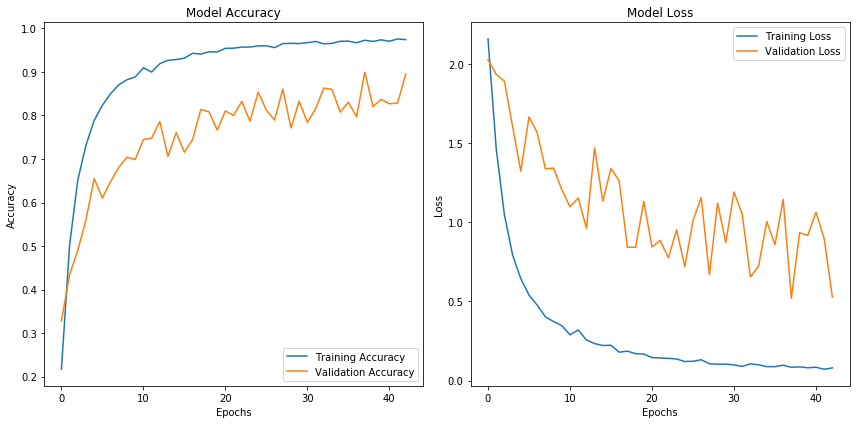

In [13]:
# Plotting training history for visualization of accuracy and loss of traing and validation

def plot_training_history(history):

    plt.figure(figsize=(12, 6))

    # Ploting training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Ploting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)  # Initial training with freeze layer


1/1 [==============================] - 0s 41ms/step


<Figure size 576x576 with 0 Axes>

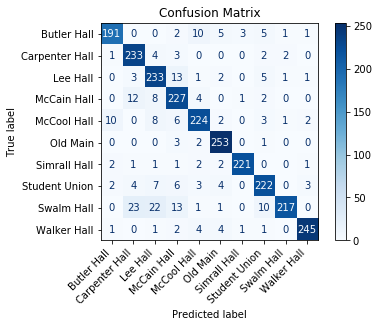

In [14]:
# Creating Confusion Matrix for training dataset

def plot_confusion_matrix(final_model, val_ds, class_names):

    y_pred = []
    y_true = []

    # Collecting predictions and true labels
    for images, labels in val_ds:
        preds = final_model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))  # Predicted class indices
        y_true.extend(labels.numpy())           # True class indices

    # Ensuring class names match the number of classes
    if len(class_names) < len(set(y_true)):
        raise ValueError("Number of class names does not match the number of unique classes in the labels.")

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display of confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    # Rotating x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')  # Rotating by 45 degrees and aligning to the right
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(final_model, val_ds, class_names=class_names) # Confusion matrix for training dataset


Predictions for Test Dataset:
1/1 [==============================] - 0s 11ms/step


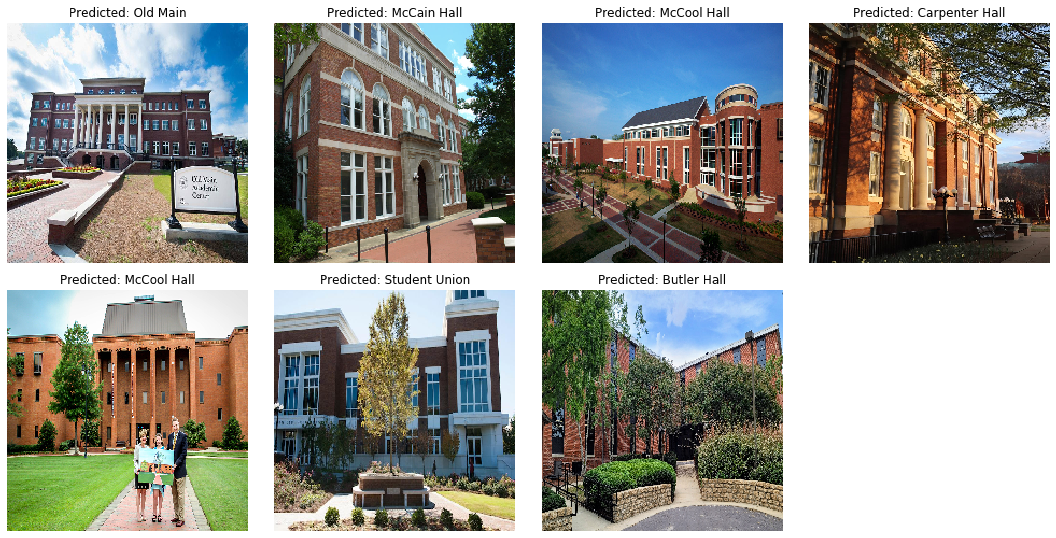

In [61]:
# Loading the final model
final_model_path = os.path.join("checkpoints", "final_model.keras")
final_model = tf.keras.models.load_model(final_model_path)

# Load class names from JSON file
with open('/home/secureslicing/Downloads/Aayam/class_names.json', 'r') as f:
    class_names = json.load(f)

# Define the test dataset path
test_dir = '/home/secureslicing/Downloads/Aayam/TestDir'

img_size = 224
predictions = []

# Set up a figure for displaying images and predictions
plt.figure(figsize=(15, 15))

counter = 1
print("Predictions for Test Dataset:")
for img_file in os.listdir(test_dir):
    if img_file.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_dir, img_file)

        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        preds = final_model.predict(img_array)
        predicted_class_index = np.argmax(preds, axis=1)[0]

        # Store the prediction along with the image filename
        predictions.append((img_file, class_names[predicted_class_index]))

        # Display the image and prediction
        plt.subplot(4, 4, counter)
        plt.imshow(img)
        plt.title(f"Predicted: {class_names[predicted_class_index]}")
        plt.axis('off')
        
        counter += 1

plt.tight_layout()
plt.show()